In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

import PySUSSIX.f90sussix.f90sussix as f90sussix
from PySUSSIX.f90sussix.sussix import  F90Sussix

import PySUSSIX.crossref as crossref

import PySUSSIX.ducksussix.duckroutines as duckroutines
import PySUSSIX.ducksussix.ducksussix as ducksussix

In [2]:
particle0 = pd.read_parquet('data/TEST_BUNCH_0000_XPLANE_ZETA_0.parquet')
particle1 = pd.read_parquet('data/TEST_BUNCH_0000_XPLANE_ZETA_1.parquet')


,Q,A
0,0.314811,5.117629
1,0.370377,0.186963
2,0.312945,0.041125
3,0.316678,0.041329
4,0.055566,0.026459


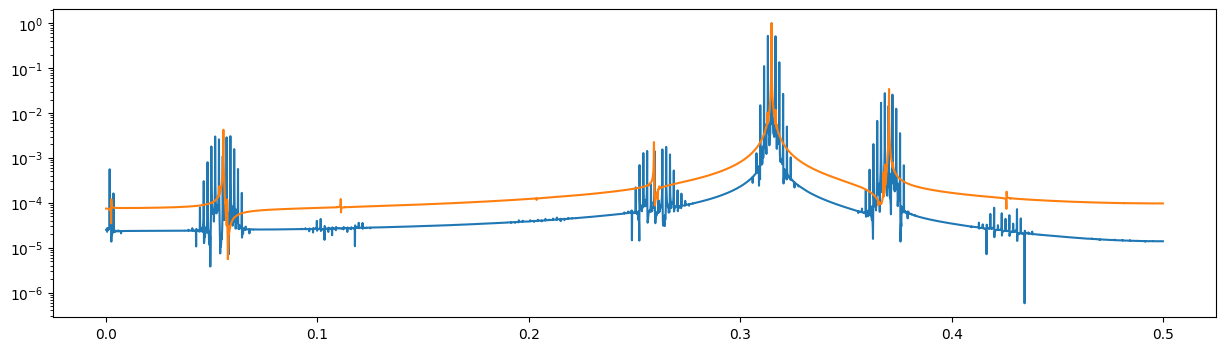

In [3]:
def get_FFT(x):
    x     = np.array(x)
    turns = np.arange(1,len(x)+1)

    freq  = np.fft.fftfreq(turns.shape[-1])
    spectrum = np.fft.fft(x-np.mean(x))

    idx      = np.argmax(np.abs(spectrum))
    Qx       = freq[idx]
    return freq[freq>0],np.abs(spectrum)[freq>0]




plt.figure(figsize=(15,4))
freq,spectrum = get_FFT(particle1.x_sig)
plt.plot(freq,spectrum/np.max(spectrum),'-')

freq,spectrum = get_FFT(particle0.x_sig)
plt.plot(freq,spectrum/np.max(spectrum),'-')
# plt.plot(Q,A/np.max(A),'o')
plt.yscale('log')

import NAFFlib
def NAFFlib_tune(x,nfreqs = 1,Hann_order=2,multiparticles = False):

    

    # No need to remove average, already done.
    if multiparticles:
        x = np.array(x)
        Q = NAFFlib.multiparticle_tunes(x, order=Hann_order)

        Q[Q<0] = np.nan
        return Q

    else:
        x        = np.array(x)
        Q,A,An  = NAFFlib.get_tunes(x, nfreqs, Hann_order)
        # Q,A      = NAFFlib.get_tunes_all(x, nfreqs, Hann_order)

        # np.abs(Ap[i]) is the amplitude
        if nfreqs ==1:
            return Q[0]
        else:
            # return Q,np.abs(Ap),np.abs(An)
            return Q,np.abs(A)
        


Q,A = NAFFlib_tune(particle0.x_sig,nfreqs=5,Hann_order=2,multiparticles = False)
pd.DataFrame({'Q':Q,'A':A})

---
# Testing main program
---

In [4]:
SS = F90Sussix()
SS.sussix_inp(nt1   = 1, 
              nt2   = len(particle0.x_sig),
              idam  = 3,
              ir    = 1,
              tunex = 0.31,
              tuney = 0.32,
              istun = None,
              nline = 0)


SS.sussix(  particle0.x_sig,particle0.px_sig,
            particle0.y_sig,particle0.py_sig,
            particle0.zeta_sig,particle0.pzeta_sig,)
df = pd.DataFrame({'ax':SS.ax,'ox':SS.ox,'ay':SS.ay,'oy':SS.oy})#,'y':y,'py':py})
# df = df[df.ox>0]
# df.sort_values('ox',inplace=True)
# df = df.reset_index(drop=True)
df.head(10)

 X TUNE DIFFERENT FROM EXPECTED


,ax,ox,ay,oy
0,5.117726,3.148115e-01,0.130927,3.173535e-01
1,5.117774,-3.148115e-01,0.130927,-3.173535e-01
2,0.186964,3.703771e-01,0.097028,-3.148114e-01
3,0.186975,-3.703771e-01,0.097024,3.148114e-01
4,0.114162,-2.385124e-11,0.027624,3.703770e-01
5,0.041474,3.166784e-01,0.027621,-3.703770e-01
6,0.041472,-3.166784e-01,0.015792,-3.122693e-01
7,0.041379,3.129444e-01,0.015792,3.122693e-01
8,0.041375,-3.129444e-01,0.010707,-5.225744e-12
9,0.026451,-5.556555e-02,0.011567,3.678351e-01


 -0.31481147556828426       0.31000000000000000     
 EXPECTED TUNE X FOUND AT LINE           2
 Y TUNE DIFFERENT FROM EXPECTED
 -0.31735353877468614       0.32000000000000001     
 EXPECTED TUNE Y FOUND AT LINE           2
 Y TUNE DIFFERENT FROM EXPECTED
  -1.8660974207716056E-003   1.0000000000000000E-003
 EXPECTED TUNE S FOUND AT LINE           2


---
# Testing subroutines
---

## spectrum

In [8]:
duckroutines.spectrum(particle0.y_sig,particle0.py_sig,number_of_harmonics = 5,method = 'hanning',return_values = True)

,tune,zpesi
0,0.317354,0.0
1,-0.317354,0.0
2,0.314811,0.0
3,-0.314811,0.0
4,-0.370377,0.0



## tunenewt and tunelasr

In [6]:
print(duckroutines.tunenewt(particle0.x_sig,particle0.px_sig))
print(duckroutines.tunelasr(particle0.x_sig,particle0.px_sig))

0.31481146763886003
0.31481147556828426


---
# Testing main sections of the code
---

In [7]:
ducksussix.datspe(  particle0.x_sig,particle0.px_sig,
                    particle0.y_sig,particle0.py_sig,
                    particle0.zeta_sig,particle0.pzeta_sig,
                    number_of_harmonics = 5,method = 'hanning',return_values = True)

,zxpes,txa,zypes,tya,zspes,tsa
0,-1.124772-4.992496j,3.148115e-01,-1.124772-4.992496j,0.317354,-1.124772-4.992496j,0.317354
1,-1.124772+4.992496j,-3.148115e-01,-1.124772+4.992496j,-0.317354,-1.124772+4.992496j,-0.317354
2,-0.142537-0.120989j,-3.703771e-01,-0.142537-0.120989j,0.314811,-0.142537-0.120989j,0.314811
3,-0.142537+0.120989j,3.703771e-01,-0.142537+0.120989j,-0.314811,-0.142537+0.120989j,-0.314811
4,-0.114137+0.000000j,-4.525156e-22,-0.114137+0.000000j,-0.370377,-0.114137+0.000000j,-0.370377
